In [1]:
%run ./data_utils.ipynb
%run ./model.ipynb

In [2]:
dataUtils = DataUtils(captions_path, images_path, min_word_frequency = 5)
im_train, im_test, cap_trin, cap_test = dataUtils.get_images_and_captions(test_size = 0.25)

loading images ...
---done!---
loading captions ...
---done!---
creating vocabulary ...
---done!---
images: 8091 captions: 8091 Vocab: 2994


two women on a grassy hill lit by the sun ; one looks at a dachshund , the other looks to the
[1, 41, 241, 23, 4, 143, 298, 864, 77, 16, 149, 904, 109, 188, 5, 4, 2400, 25, 16, 46, 188, 32, 16, 2]


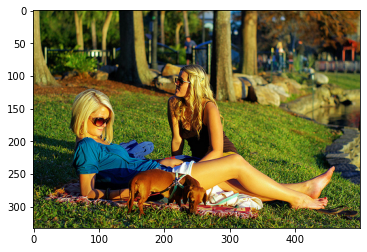

In [3]:
plt.imshow(im_train[5])
print(dataUtils.reverse_numericalize(cap_trin[5]))
print(cap_trin[5])

In [4]:
embed_size = 300
hidden_size = 256
vocab_size = len(dataUtils.vocabulary)
num_layers = 1
learning_rate = 6e-4
num_epochs = 20
load_model = False
save_model = True
bidir_lstm = True
train_CNN = False
batch_size = 16

In [5]:
transform = transforms.Compose(
        [
            transforms.ToPILImage(),
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

train_data = Dataset(im_train, cap_trin, transform = transform)
test_data = Dataset(im_test, cap_test, transform = transform)

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=train_data, batch_size=20, shuffle=True)

In [6]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
writer = SummaryWriter("runs/flickr")
step = 0

In [8]:
model = CptioningNetwork(embed_size, hidden_size, vocab_size, num_layers, train_CNN = train_CNN, bidir_lstm = bidir_lstm).to(device)
criterion = nn.CrossEntropyLoss(ignore_index = dataUtils.rev_vocabulary["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

if load_model:
    step = load_checkpoint(torch.load("my_checkpoint.pth.tar"), model, optimizer)

In [9]:
train_losses = []
test_losses = []

In [10]:
model.train()

for epoch in range(num_epochs):
    batches_losses = []
    if save_model:
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "step": step,
        }
        save_checkpoint(checkpoint)

    for idx, (imgs, captions) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
        imgs = imgs.to(device)
        captions = captions.to(device)

        outputs = model(imgs, captions[:, :-1])
        loss = criterion(
            outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
        )
        
        batches_losses.append(loss.item())
        writer.add_scalar("Training loss per itr", loss.item(), global_step=step)
        step += 1
        
        optimizer.zero_grad()
        loss.backward(loss)
        optimizer.step()
        
    train_losses.append(np.array(batches_losses).mean())
    test_loss = caption_test(model, test_data, log = False)
    test_losses.append(test_loss)
    writer.add_scalar("Test loss", test_loss, global_step=epoch)
    writer.add_scalar("Train loss", np.array(batches_losses).mean(), global_step=epoch)
    writer.add_scalar("Train loss (test mode)", caption_test(model, train_data, log = False), global_step=epoch)    

  0%|          | 0/380 [00:00<?, ?it/s]

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]          

=> Saving checkpoint


  0%|          | 0/380 [00:00<?, ?it/s]             

=> Saving checkpoint


KeyboardInterrupt: 

In [ ]:
caption_test(model, train_data, log = True)

In [ ]:
caption_test(model, test_data, log = True)